## Exercises

Import relevant packages

If you have trouble downloading data from the USGS or from NOAA, click here:

* <a href="USGS 03337100 BONEYARD CREEK AT LINCOLN AVE AT URBANA, IL.dat" download>USGS streamflow data</a>
* <a href="CRNS0101-05-2020-IL_Champaign_9_SW.txt" download>NOAA atmospheric data</a>
* <a href="HEADERS.txt" download>NOAA headers file</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from ipywidgets import *

Import streamflow data from USGS's  [National Water Information System](https://maps.waterdata.usgs.gov/mapper/index.html). We will be using data from [Urbana, IL](https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=03337100).

* Choose `Discharge`
* Change time span to year 2020
* Select data to retrieve `Primary time series`
* Click on `Download data` button

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_65624/154551529.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_q_2020 = pd.read_csv(data_file,


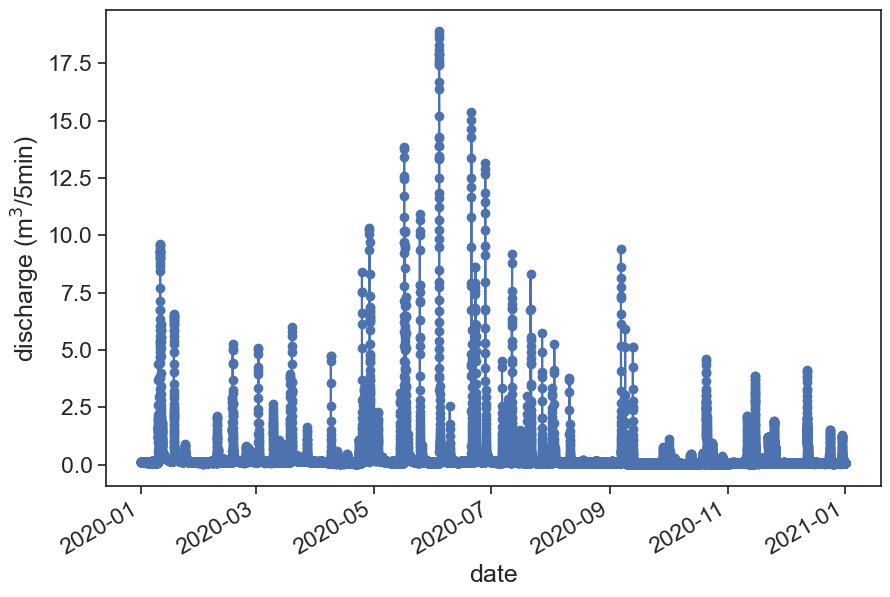

In [2]:
# Drainage area: 4.78 square miles   
data_file = "USGS 03337100 BONEYARD CREEK AT LINCOLN AVE AT URBANA, IL.dat"
df_q_2020 = pd.read_csv(data_file,
                        header=31,                      # no headers needed, we'll do that later
                        delim_whitespace=True,            # blank spaces separate between columns
                        na_values=["Bkw"]  # substitute these values for missing (NaN) values
                )
df_q_2020.columns = ['agency_cd', 'site_no','datetime','tz_cd','EDT','discharge','code']                       # rename df columns with headers columns
df_q_2020['date_and_time'] = df_q_2020['datetime'] + ' ' + df_q_2020['tz_cd'] # combine date+time into datetime
df_q_2020['date_and_time'] = pd.to_datetime(df_q_2020['date_and_time'])        # interpret datetime
df_q_2020 = df_q_2020.set_index('date_and_time')                          # make datetime the index
df_q_2020['discharge'] = df_q_2020['discharge'].astype(float)
df_q_2020['discharge'] = df_q_2020['discharge'] * 0.0283168 # convert cubic feet to m3

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(df_q_2020['discharge'], '-o')
plt.gcf().autofmt_xdate()
ax.set(xlabel="date",
       ylabel=r"discharge (m$^3$/5min)");

Import sub-hourly (5-min) rainfall data from NOAA's [Climate Reference Network Data](https://www.ncdc.noaa.gov/crn/qcdatasets.html) website

In [3]:
data_file = "CRNS0101-05-2020-IL_Champaign_9_SW.txt"
df_p_2020 = pd.read_csv(data_file,
                        header=None,                      # no headers needed, we'll do that later
                        delim_whitespace=True,            # blank spaces separate between columns
                        na_values=["-99.000", "-9999.0"]  # substitute these values for missing (NaN) values
                       )
headers = pd.read_csv("HEADERS.txt",    # load headers file
                      header=1,                    # skip the first [0] line
                      delim_whitespace=True
                     )
df_p_2020.columns = headers.columns                       # rename df columns with headers columns
# LST = local standard time
df_p_2020["LST_TIME"] = [f"{x:04d}" for x in df_p_2020["LST_TIME"]]  # time needs padding of zeros, then convert to string
df_p_2020['LST_DATE'] = df_p_2020['LST_DATE'].astype(str)            # convert date into string
df_p_2020['datetime'] = df_p_2020['LST_DATE'] + ' ' + df_p_2020['LST_TIME'] # combine date+time into datetime
df_p_2020['datetime'] = pd.to_datetime(df_p_2020['datetime'])        # interpret datetime
df_p_2020 = df_p_2020.set_index('datetime')                          # make datetime the index

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_65624/3302633013.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_p_2020 = pd.read_csv(data_file,
/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_65624/3302633013.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  headers = pd.read_csv("HEADERS.txt",    # load headers file


Plot rainfall and streamflow. Does this makes sense?

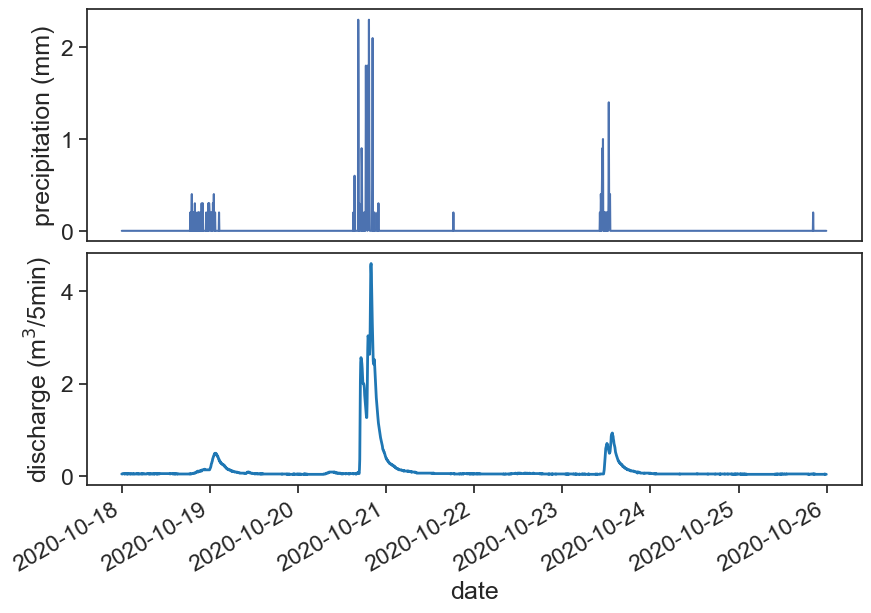

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
fig.subplots_adjust(hspace=0.05)

start = "2020-10-18"
end = "2020-10-25"
ax1.plot(df_p_2020[start:end]['PRECIPITATION'])
ax2.plot(df_q_2020[start:end]['discharge'], color="tab:blue", lw=2)

ax1.set(xticks=[],
        ylabel=r"precipitation (mm)")
ax2.set(xlabel="date",
        ylabel=r"discharge (m$^3$/5min)")

plt.gcf().autofmt_xdate()  # makes slanted dates

Define smaller dataframes for $p(t)$ and $q(t)$, between the dates:  
```python
start = "2020-10-20 14:00:00"
end = "2020-10-21 04:00:00"
```

Don't forget to convert the units to SI!

Calculate total rainfall $P^*$ and total discharge $Q^*$, in m$^3$.

In [7]:
# Drainage area: 4.78 square miles
area = 4.78 / 0.00000038610  # squared miles to squared meters
start = "2020-10-20 14:00:00"
end = "2020-10-21 04:00:00"

df_p = df_p_2020.loc[start:end]['PRECIPITATION'].to_frame()
df_p_mm = df_p_2020.loc[start:end]['PRECIPITATION'].to_frame()
df_q = df_q_2020.loc[start:end]['discharge'].to_frame()

df_p['PRECIPITATION'] = df_p['PRECIPITATION'].values * area / 1000  # mm to m3 in the whole watershed
df_p['PRECIPITATION'] = df_p['PRECIPITATION'] / 60 / 5 # convert m3 per 5 min to m3/s

P = df_p['PRECIPITATION'].sum() * 60 * 5
Q = df_q['discharge'].sum() * 60 * 5

print("total precipitation during event: P = {:.1e} m3".format(P.sum()))
print("total streamflow during event: Q = {:.1e} m3".format(Q.sum()))

total precipitation during event: P = 2.6e+05 m3
total streamflow during event: Q = 5.2e+04 m3


Make another graph of $p(t)$ and $q(t)$, now with SI units.

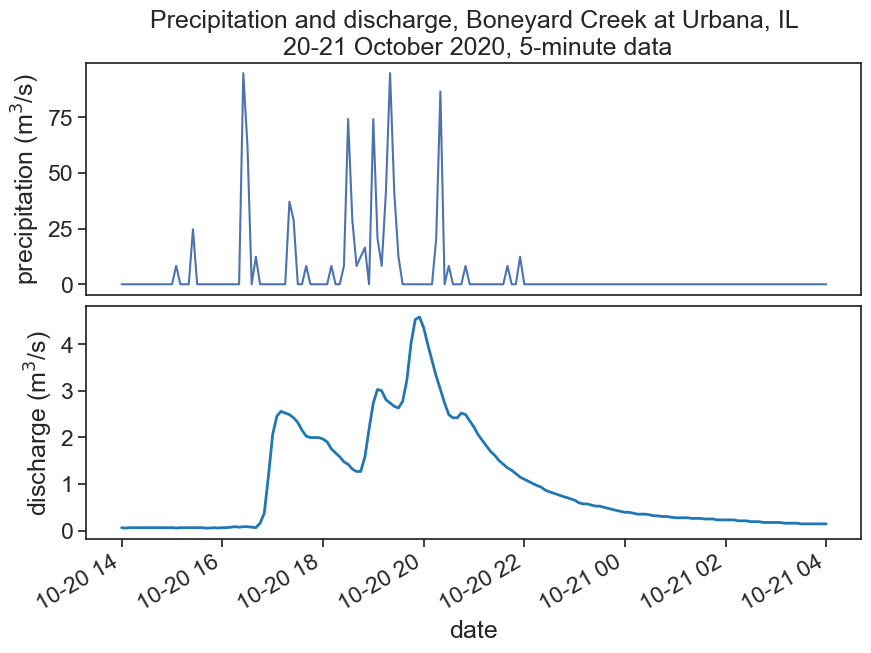

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7))
fig.subplots_adjust(hspace=0.05)

start = "2020-10-18"
end = "2020-10-25"
ax1.plot(df_p['PRECIPITATION'])
ax2.plot(df_q['discharge'], color="tab:blue", lw=2)

ax1.set(xticks=[],
        ylabel=r"precipitation (m$^3$/s)",
        title="Precipitation and discharge, Boneyard Creek at Urbana, IL\n 20-21 October 2020, 5-minute data")
ax2.set(xlabel="date",
        ylabel=r"discharge (m$^3$/s)")

plt.gcf().autofmt_xdate()  # makes slated dates

It's time for base flow separation! Convert $q(t)$ into $q^*(t)$

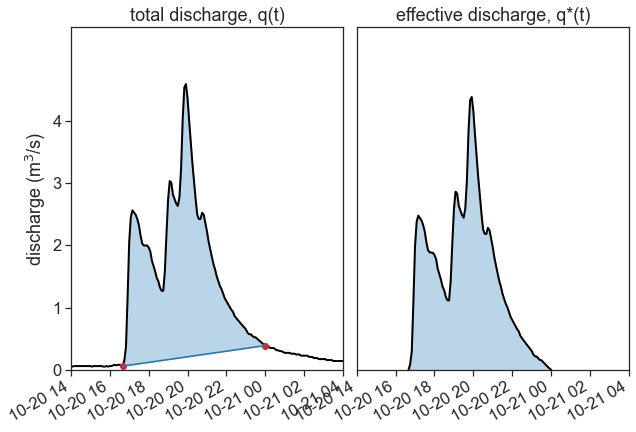

In [31]:
from matplotlib.dates import HourLocator, DateFormatter
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))
fig.subplots_adjust(wspace=0.05)

ax1.plot(df_q['discharge'], color="black", lw=2)
point1 = pd.to_datetime("2020-10-20 16:40:00")
point2 = pd.to_datetime("2020-10-21 00:00:00")
two_points = df_q.loc[[point1, point2]]['discharge']
ax1.plot(two_points, 'o', color="tab:red")

new = pd.DataFrame(data=two_points, index=two_points.index)

df_linear = (new.resample("5min") #resample
                .interpolate(method='time') #interpolate by time
            )

ax1.plot(df_linear, color="tab:blue")

df_between_2_points = df_q.loc[df_linear.index]
ax1.fill_between(df_between_2_points.index, df_between_2_points['discharge'],
                 y2=df_linear['discharge'],
                 color="tab:blue", alpha=0.3)

qstar = df_q.loc[df_linear.index]['discharge'] - df_linear['discharge']
Qstar = qstar.sum() * 60 * 5

ax2.plot(qstar, color="black", lw=2)
ax2.fill_between(qstar.index, qstar,
                 y2=0.0,
                 color="tab:blue", alpha=0.3)

ax1.set(xlim=[df_q.index[0],
              df_q.index[-1]],
        ylabel=r"discharge (m$^3$/s)",
        ylim=[0, 5.5],
        yticks=[0,1,2,3,4],
        title="total discharge, q(t)")
ax2.set(yticks=[],
        ylim=[0, 5.5],
        xlim=[df_q.index[0],
              df_q.index[-1]],
        title="effective discharge, q*(t)"
       )

plt.gcf().autofmt_xdate()  # makes slated dates

We can calculate $p^*$ now, using

$$
P^* = Q^*
$$

One of the simplest methods is to multiply $p(t)$ by a fixed constant (<1) to obtain $p^*$, so that the equation above holds true.

In [33]:
ratio = Qstar/ P
pstar = df_p['PRECIPITATION'] * ratio
Pstar = pstar.sum() * 5 * 60
print(f"Qstar / P = {ratio:.2f}")

Qstar / P = 0.16


Calculate now the centroid ($t_pc$) for effective precipitation $p^*$ and centroid ($t_{qc}$) of effective discharge $q^*$. Calculate also the time of peak discharge ($t_{pk}$). Then, calculate the centroid lag ($T_{LC}$), the centroid lag-to-peak ($T_{LPC}$), and the time of concentration ($T_c$). Use the equations below:

$T_{LPC} \simeq 0.60 \cdot T_c$

Time of precipitation centroid:

$$
t_{pc} = \frac{\displaystyle \sum_{i=1}^n p_i^* \cdot t_i}{P^*}
$$

Time of streamflow centroid:

$$
t_{qc} = \frac{\displaystyle \sum_{i=1}^n q_i^* \cdot t_i}{Q^*}
$$


Centroid lag:

$$
T_{LC} = t_{qc} - t_{pc}
$$

Centroid lag-to-peak:
$$
T_{LPC} = t_{pk} - t_{pc}
$$


Time of concentration:
$$
T_{LPC} \simeq 0.60 \cdot T_c
$$

In [34]:
# pstar centroid
# time of the first (nonzero) rainfall data point
t0 = pstar[pstar != 0.0].index[0]
# time of the last (nonzero) rainfall data point
tf = pstar[pstar != 0.0].index[-1]
# duration of the rainfall event, in minutes
td = (tf-t0) / pd.Timedelta('1 min')
# make time array, add 2.5 minutes (half of dt)
time = np.arange(0, td+1, 5) + 2.5
# create pi array, only with relevant data (during rainfall duration)
pi = pstar.loc[(pstar.index >= t0) & (pstar.index <= tf)]
# convert from m3/5min to m3/s
pi = pi.values * 60 * 5
# time of precipitation centroid
t_pc = (pi * time).sum() / pi.sum()
# add initial time
t_pc = t0 + pd.Timedelta(minutes=t_pc)
t_pc

# qstar centroid
# time of the first (nonzero) discharge data point
t0 = qstar[qstar != 0.0].index[0]
# time of the last (nonzero) discharge data point
tf = qstar[pstar != 0.0].index[-1]
# duration of the discharge event, in minutes
td = (tf-t0) / pd.Timedelta('1 min')
# make time array, add 2.5 minutes (half of dt)
time = np.arange(0, td+1, 5) + 2.5
# create qi array, only with relevant data (during discharge duration)
qi = qstar.loc[(qstar.index >= t0) & (qstar.index <= tf)]
# convert from m3/5min to m3/s
qi = qi.values * 60 * 5
# time of discharge centroid
t_qc = (qi * time).sum() / qi.sum()
# add initial time
t_qc = t0 + pd.Timedelta(minutes=t_qc)
t_qc

# time of peak discharge
max_discharge = qstar.max()
t_pk = qstar[qstar == max_discharge].index[0]

# centroid lag
T_LC = t_qc - t_pc

# centroid lag-to-peak
T_LPC = t_pk - t_pc

# time of concentration
T_c = T_LPC / 0.60

print(f"T_LC = {T_LC}")
print(f"T_LPC = {T_LPC}")
print(f"T_c = {T_c}")

T_LC = 0 days 00:53:03.186594
T_LPC = 0 days 01:22:59.857820
T_c = 0 days 02:18:19.763033333
